# Merging calibration options and create $p_f$ for $C_4$ and $C_5$

- statistics of glaciers with additional in-situ data included as well

Calibration of $C_{1,2,3}$ was done in http://localhost:6261/lab/tree/Schuster_et_al_phd_paper_1_cluster/00_freq_5calib_options_ref_glaciers.py using the http://localhost:6261/lab/tree/Schuster_et_al_phd_paper_1_cluster/slurm_freq_5calib.slurm script via:
- `sbatch 01_slurm_freq_5calib.slurm "C1_C2"`
- `sbatch 01_slurm_freq_5calib.slurm "C3"`


what about -> http://localhost:6261/lab/tree/Schuster_et_al_phd_paper_1_cluster/README.txt

In [34]:
#pip install --upgrade "git+https://github.com/OGGM/oggm.git@a3123b56b3b5bac964eaab7742aa73bc2507c067"
#pip install --upgrade "git+https://github.com/lilianschuster/massbalance-sandbox.git@b6b37240868ba35944523fc2b3e493652fcb1f22"
#pip install --upgrade "git+https://github.com/OGGM/oggm-sample-data.git"

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import numpy as np
import pandas as pd
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import (process_isimip_data,
                                                        process_isimip_data_no_corr)
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf, minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel
import time
import logging

log = logging.getLogger(__name__)

In [2]:

_, pathi = utils.get_wgms_files()
pd_mb_overview = pd.read_csv(pathi[:-len('/mbdata')] + '/mb_overview_seasonal_mb_time_periods_20220301.csv',
                             index_col='Unnamed: 0')
pd_wgms_data_stats = pd.read_csv(pathi[:-len('/mbdata')] + '/wgms_data_stats_20220301.csv', index_col='Unnamed: 0')

# should have at least 5 annual MB estimates in the time period 1980-2019
# (otherwise can also not have MB profiles or winter MB!)
pd_wgms_data_stats = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=5]
ref_candidates = pd_wgms_data_stats.rgi_id.unique()
import xarray as xr
working_dir = '/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/oggm_run_gdir_folder/node_folder'
#/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/per_glacier_calib_data/cluster_freq_per_glacier_calib_data/my_run
#utils.gettempdir(dirname='OGGM_seasonal_mb_calib', reset=False)
#Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/per_glacier_calib_data/cluster_freq_per_glacier_calib_data/my_run/per_glacier
cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True #True
cfg.PATHS['working_dir'] = working_dir
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1
cfg.PARAMS['continue_on_error'] = True
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-01-10 23:46:13: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-01-10 23:46:13: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-01-10 23:46:13: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-01-10 23:46:13: oggm.cfg: Multiprocessing switched ON after user settings.
2023-01-10 23:46:13: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


In [37]:
gdirs = workflow.init_glacier_directories(ref_candidates)

2023-01-10 22:42:07: oggm.workflow: Execute entity tasks [GlacierDirectory] on 247 glaciers


In [38]:
_doc = 'the calibrated melt_f, pf and temp.b to match geodetic mean observation, winter MB and approximately std of direct annual time series'
cfg.BASENAMES['calib_geod_opt_winter_mb_approx_std'] = ('calib_geod_opt_winter_mb_approx_std.json', _doc)

_doc2 = 'the calibrated melt_f and pf to match geodetic mean observation and winter MB bias, temp. bias set to zero!'
cfg.BASENAMES['calib_geod_opt_winter_mb_temp_b_0'] = ('calib_geod_opt_winter_mb_temp_b_0.json', _doc2)

_doc3 = 'the calibrated melt_f and pf to match geodetic mean observation and interannual direct glaciological standard deviation, temp. bias set to zero!'
cfg.BASENAMES['calib_geod_opt_std_temp_b_0'] = ('calib_geod_opt_std_temp_b_0.json', _doc3)

_doc4 = 'the calibrated melt_f to match geodetic mean observation, no temp. bias and globally cte prcp. fac extracted from median of ref glacier matching direct glaciological standard deviation'
cfg.BASENAMES['calib_only_geod_temp_b_0_pf_cte_via_std'] = ('calib_only_geod_temp_b_0_pf_cte_via_std.json', _doc4)
_doc5 = 'the calibrated melt_f to match geodetic mean observation, no temp. bias and per glacier one prcp. factor extracted from median of ref glacier matching direct glaciological standard deviation'
cfg.BASENAMES['calib_only_geod_temp_b_0_pf_fit_via_winter_mb'] = ('calib_only_geod_temp_b_0_pf_fit_via_winter_mb.json', _doc5)


ValueError: DocumentedDict accepts only tuple of len 2

In [39]:
calib_types = ['calib_geod_opt_winter_mb_approx_std',
               'calib_geod_opt_winter_mb_temp_b_0',
               'calib_geod_opt_std_temp_b_0',
               'calib_only_geod_temp_b_0_pf_cte_via_std',
               'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']

**Statistics about reference glacier data stuff**

In [40]:
pd_t = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=10]
print(len(pd_t))

180


In [41]:
pd_t = pd_t.loc[pd_t.len_winter_balance_filtered>=5]
print(len(pd_t))

95


In [42]:
print(len(pd_wgms_data_stats.loc[pd_wgms_data_stats.len_winter_balance_filtered>=5]))

118


In [43]:
print(len(ref_candidates)) # with at least 5 msm ... 

247


In [44]:
##rgi_working_for_all = pd.read_csv(f'/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/rgi_working_for_all_list.csv',
#                                  index_col = 'Unnamed: 0')
#rgi_working_for_all = list(rgi_working_for_all['0'].values)

Load the calibration parameters:

In [45]:
# C2: calib_geod_opt_winter_mb_temp_b_0
ts = []
missing_no_sfc_type = []
missing_sfc_type = []
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_winter_mb_no_sfc_type_{rgi_id}_methodpre-check.csv',
                        index_col = 'Unnamed: 0')
        ts.append(f)

    except:
        try:
            f = pd.read_csv(f'{path_calib_data}/calib_winter_mb_monthly_no_sfc_type_{rgi_id}_methodpre-check.csv', index_col = 'Unnamed: 0')
            ts.append(f)
            print(rgi_id)
        except:
            missing_no_sfc_type.append(rgi_id)
            pass

for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_winter_mb_monthly_melt_f_update_{rgi_id}_methodpre-check.csv', index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        missing_sfc_type.append(rgi_id)
pd_calib =pd.concat(ts)
pd_calib = pd_calib.dropna(subset=['pf_opt', 'melt_f'])
pd_calib['changing melt_f with sfc type'] = pd_calib['melt_f_change']
pd_calib.loc[pd_calib.sfc_type_distinction==False, 'changing melt_f with sfc type'] = False
pd_calib['changing melt_f with sfc type'].loc[pd_calib.melt_f_change == 'neg_exp'] += '_t' + pd_calib['tau_e_fold_yr'].loc[pd_calib.melt_f_change == 'neg_exp'].astype(str)+'yr' 
pd_calib_temp_b_0 = pd_calib.loc[pd_calib.temp_bias == 0]


# C1: calib_geod_opt_winter_mb_approx_std
# do not try to match perfectly std. quot but only that it deviates < 10%, then choose the one with smallest temp. bias
exact_std_quot = False
load = True
if load:
    rgi_id_dict = {}
    rgi_id_len_dict = {}
    pd_calib_opt_quot_std_ls =  []
    for sfc_type in ['linear', 'neg_exp_t0.5yr',  'neg_exp_t1.0yr',
                     'linear_annual', 'neg_exp_annual_t1.0yr', 'neg_exp_annual_t0.5yr', False]:
    # for sfc_type in [False, 'linear', 'neg_exp']:
        pd_calib_pre_sel = pd_calib.loc[pd_calib['changing melt_f with sfc type']==sfc_type]
        for mb_type in pd_calib_pre_sel.mb_type.unique():
            pd_calib_sel = pd_calib_pre_sel.loc[pd_calib_pre_sel.mb_type == mb_type]
            for grad_type in pd_calib.grad_type.unique():
                pd_calib_sel_sel = pd_calib_sel.loc[pd_calib_sel.grad_type == grad_type]
                #print(len(pd_calib_sel_sel))
                rgi_id_dict[f'sfc_type_distinction_{sfc_type}_{mb_type}_{grad_type}'] = pd_calib_sel_sel.rgi_id.unique()
                rgi_id_len_dict[f'sfc_type_distinction_{sfc_type}_{mb_type}_{grad_type}'] = len(pd_calib_sel_sel.rgi_id.unique())

                for rgi in pd_calib_sel_sel.rgi_id.unique():
                    pd_calib_rgi = pd_calib_sel_sel[pd_calib_sel_sel.rgi_id == rgi]
                    if exact_std_quot:
                        opt_quot_std =  pd_calib_rgi.iloc[np.abs(np.array(pd_calib_rgi.quot_std-1)).argmin()]
                    else:
                        try:
                            # if there is one or several temp.b bias with std. deviating less than 10%,
                            # chooose the one with the smallest temp. bias
                            pd_calib_rgi_quot_std_choices = pd_calib_rgi[np.abs(pd_calib_rgi.quot_std-1)<0.1]
                            opt_quot_std = pd_calib_rgi_quot_std_choices.iloc[np.abs(pd_calib_rgi_quot_std_choices.temp_bias).argmin()]
                        except:
                            opt_quot_std =  pd_calib_rgi.iloc[np.abs(np.array(pd_calib_rgi.quot_std-1)).argmin()]

                    pd_calib_opt_quot_std_ls.append(pd.DataFrame(opt_quot_std).T)

    # first select again the opt_std
    pd_calib_geod_opt_winter_mb_approx_std = pd.concat(pd_calib_opt_quot_std_ls)
    working_mb_profile_len = len(pd_calib_geod_opt_winter_mb_approx_std.mae_mb_profile.dropna())
    working_mb_profile_len_opt_quot = len(pd_calib_geod_opt_winter_mb_approx_std.mae_mb_profile.dropna())
    pd_calib_geod_opt_winter_mb_approx_std.to_csv(f'{path_calib_data}/calib_opt_quot_std_approx_std_match.csv')
    print(rgi_id_len_dict)
else:
    pd_calib_geod_opt_winter_mb_approx_std = pd.read_csv(f'{path_calib_data}/calib_opt_quot_std_approx_std_match.csv',
                                                         index_col = ['Unnamed: 0'])


# C3: calib_geod_opt_std_temp_b_0
ts = []
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_std_quot_no_sfc_type_{rgi_id}_methodpre-check.csv',
                        index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass
print(len(ts))
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_std_quot_monthly_melt_f_update_{rgi_id}_methodpre-check.csv', index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass
print(len(ts)-247)
   
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_std_quot_annual_melt_f_update_{rgi_id}_methodpre-check.csv', index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass
print(len(ts)-247-247)

pd_calib_std_quot_temp_b_0 = pd.concat(ts)
# remove NaNs
pd_calib_std_quot_temp_b_0 = pd_calib_std_quot_temp_b_0.dropna(subset=['pf_opt', 'melt_f'])
pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'] = pd_calib_std_quot_temp_b_0['melt_f_change']
pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'].loc[pd_calib_std_quot_temp_b_0.melt_f_update == 'annual'] = pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'].loc[pd_calib_std_quot_temp_b_0.melt_f_update == 'annual'].values + '_' + 'annual'
pd_calib_std_quot_temp_b_0.loc[pd_calib_std_quot_temp_b_0.sfc_type_distinction==False, 'changing melt_f with sfc type'] = False
pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'].loc[pd_calib_std_quot_temp_b_0.melt_f_change == 'neg_exp'] += '_t' + pd_calib_std_quot_temp_b_0['tau_e_fold_yr'].loc[pd_calib_std_quot_temp_b_0.melt_f_change == 'neg_exp'].astype(str)+'yr' 
#'_t'+ pd_calib_std_quot_temp_b_0['tau_e_fold_yr'].loc[pd_calib_std_quot_temp_b_0.melt_f_change == 'neg_exp'].values.astype(str)


pd_calib_type_dict = {'calib_geod_opt_winter_mb_approx_std': pd_calib_geod_opt_winter_mb_approx_std,
                      'calib_geod_opt_winter_mb_temp_b_0': pd_calib_temp_b_0,
                      'calib_geod_opt_std_temp_b_0': pd_calib_std_quot_temp_b_0,
                      }

/tmp/ipykernel_187646/86176513.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib['changing melt_f with sfc type'].loc[pd_calib.melt_f_change == 'neg_exp'] += '_t' + pd_calib['tau_e_fold_yr'].loc[pd_calib.melt_f_change == 'neg_exp'].astype(str)+'yr'


{'sfc_type_distinction_linear_mb_monthly_cte': 110, 'sfc_type_distinction_linear_mb_monthly_var_an_cycle': 110, 'sfc_type_distinction_linear_mb_pseudo_daily_cte': 110, 'sfc_type_distinction_linear_mb_pseudo_daily_var_an_cycle': 110, 'sfc_type_distinction_linear_mb_pseudo_daily_fake_cte': 109, 'sfc_type_distinction_linear_mb_pseudo_daily_fake_var_an_cycle': 109, 'sfc_type_distinction_linear_mb_real_daily_cte': 110, 'sfc_type_distinction_linear_mb_real_daily_var_an_cycle': 110, 'sfc_type_distinction_neg_exp_t0.5yr_mb_monthly_cte': 110, 'sfc_type_distinction_neg_exp_t0.5yr_mb_monthly_var_an_cycle': 110, 'sfc_type_distinction_neg_exp_t0.5yr_mb_pseudo_daily_cte': 110, 'sfc_type_distinction_neg_exp_t0.5yr_mb_pseudo_daily_var_an_cycle': 110, 'sfc_type_distinction_neg_exp_t0.5yr_mb_pseudo_daily_fake_cte': 109, 'sfc_type_distinction_neg_exp_t0.5yr_mb_pseudo_daily_fake_var_an_cycle': 109, 'sfc_type_distinction_neg_exp_t0.5yr_mb_real_daily_cte': 110, 'sfc_type_distinction_neg_exp_t0.5yr_mb_real_d

/tmp/ipykernel_187646/86176513.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'].loc[pd_calib_std_quot_temp_b_0.melt_f_update == 'annual'] = pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'].loc[pd_calib_std_quot_temp_b_0.melt_f_update == 'annual'].values + '_' + 'annual'
/tmp/ipykernel_187646/86176513.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'].loc[pd_calib_std_quot_temp_b_0.melt_f_change == 'neg_exp'] += '_t' + pd_calib_std_quot_temp_b_0['tau_e_fold_yr'].loc[pd_calib_std_quot

### Get median prcp-fac and then create "C4" and save it

In [46]:
### GET median prcp-fac for the calib_only_geod_temp_b_0_pf_cte_via_std option!!!
pd_calib_std_quot_temp_b_0.index = pd_calib_std_quot_temp_b_0.rgi_id
ref_candidates_10_annual_balance = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>= 10].rgi_id.values

working_rgi_l = []
for sfc_type in ['linear', 'neg_exp_t0.5yr',  'neg_exp_t1.0yr', 'linear_annual', 'neg_exp_annual_t1.0yr', 'neg_exp_annual_t0.5yr', False]:
    pd_sel1 = pd_calib_std_quot_temp_b_0.loc[pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'] == sfc_type]
    for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_pseudo_daily_fake','mb_real_daily']:
            pd_sel2 = pd_sel1.loc[pd_sel1.mb_type == mb_type]
            for grad_type in ['cte', 'var_an_cycle']:
                pd_sel3 = pd_sel2.loc[pd_sel2.grad_type == grad_type]
                l = pd_sel3.rgi_id.unique()
                #print(len(l))
                if sfc_type == 'linear' and mb_type == 'mb_monthly' and grad_type == 'cte':
                    working_rgi_l = l
                else:
                    working_rgi_l = list(set(working_rgi_l).intersection(l))
        
# print number of glaciers that work for all options (of that calib type):
len(working_rgi_l)

192

In [47]:
# TODO: if this is wanted --> need to recompute the rgi_working_for_all !!!
#rgi_working_for_all = pd.read_csv(f'/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/rgi_working_for_all_list.csv', index_col = 'Unnamed: 0')
#rgi_working_for_all = list(rgi_working_for_all['0'].values)

# get median pf for each option:
# take all glaciers that have at least 10 years of annual balance! (and work for all options!)
ref_candidates_10_annual_balance = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>= 10].rgi_id.values
ref_candidates_10_annual_balance = list(set(working_rgi_l).intersection(ref_candidates_10_annual_balance))
print(len(ref_candidates_10_annual_balance))
run = True
if run:
    pf_cte_dict_std_quot_temp_b_0 = {}
    #pf_cte_dict_std_quot_temp_b_0_working_for_all = {}
    for sfc_type in ['linear', 'neg_exp_t0.5yr',  'neg_exp_t1.0yr',
                     'linear_annual', 'neg_exp_annual_t1.0yr', 'neg_exp_annual_t0.5yr', False]:
        pd_sel1 = pd_calib_std_quot_temp_b_0.loc[pd_calib_std_quot_temp_b_0['changing melt_f with sfc type'] == sfc_type]
        pd_sel1 = pd_sel1.loc[ref_candidates_10_annual_balance]
        for mb_type in ['mb_monthly', 'mb_pseudo_daily',
                        'mb_pseudo_daily_fake', 'mb_real_daily']:
            pd_sel2 = pd_sel1.loc[pd_sel1.mb_type == mb_type]
            for grad_type in ['cte', 'var_an_cycle']:
                pd_sel3 = pd_sel2.loc[pd_sel2.grad_type == grad_type]
                if 'annual' in str(sfc_type):
                    melt_f_update = 'annual'
                    if 'neg_exp' in str(sfc_type):
                        sfc_type_sub = sfc_type[:-len('annual_t0.5yr')-1]+sfc_type[-7:]
                    else:
                        sfc_type_sub = sfc_type[:-len('annual')-1]
                elif sfc_type is not False:
                    melt_f_update = 'monthly'
                    sfc_type_sub = sfc_type
                if sfc_type is not False:
                    pd_sel4 = pd_sel3.loc[pd_sel3.melt_f_update == melt_f_update]
                    key = f'{melt_f_update}_melt_f_update_sfc_type_{sfc_type_sub}_{mb_type}_{grad_type}'
                else:
                    pd_sel4 = pd_sel3.copy()
                    key = f'sfc_type_{sfc_type}_{mb_type}_{grad_type}'
                # different to before --> it is the median of all glaciers 
                print(sfc_type, melt_f_update, len(pd_sel4))
                pf_cte_dict_std_quot_temp_b_0[key] = pd_sel4.pf_opt.median()

    import json  
    with open(f"{fpath}/0_pf_cte_median_dict_std_quot_temp_b_0.json", "w") as outfile:
        json.dump(pf_cte_dict_std_quot_temp_b_0, outfile)

147
linear monthly 147
linear monthly 147
linear monthly 147
linear monthly 147
linear monthly 147
linear monthly 147
linear monthly 147
linear monthly 147
neg_exp_t0.5yr monthly 147
neg_exp_t0.5yr monthly 147
neg_exp_t0.5yr monthly 147
neg_exp_t0.5yr monthly 147
neg_exp_t0.5yr monthly 147
neg_exp_t0.5yr monthly 147
neg_exp_t0.5yr monthly 147
neg_exp_t0.5yr monthly 147
neg_exp_t1.0yr monthly 147
neg_exp_t1.0yr monthly 147
neg_exp_t1.0yr monthly 147
neg_exp_t1.0yr monthly 147
neg_exp_t1.0yr monthly 147
neg_exp_t1.0yr monthly 147
neg_exp_t1.0yr monthly 147
neg_exp_t1.0yr monthly 147
linear_annual annual 147
linear_annual annual 147
linear_annual annual 147
linear_annual annual 147
linear_annual annual 147
linear_annual annual 147
linear_annual annual 147
linear_annual annual 147
neg_exp_annual_t1.0yr annual 147
neg_exp_annual_t1.0yr annual 147
neg_exp_annual_t1.0yr annual 147
neg_exp_annual_t1.0yr annual 147
neg_exp_annual_t1.0yr annual 147
neg_exp_annual_t1.0yr annual 147
neg_exp_annual

**have to run `sbatch slurm_freq_5calib.slurm "C4"` in the terminal**

In [48]:
# C4: 
# calib_only_geod_temp_b_0_pf_cte_via_std
ts = []
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_only_geod_no_sfc_type_pf_cte_via_std_{rgi_id}_methodpre-check.csv',
                        index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_only_geod_monthly_melt_f_update_pf_cte_via_std_{rgi_id}_methodpre-check.csv',
                        index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass

for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_only_geod_annual_melt_f_update_pf_cte_via_std_{rgi_id}_methodpre-check.csv', index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass

pd_calib_only_geod_temp_b_0_pf_cte_via_std = pd.concat(ts)
pd_calib_only_geod_temp_b_0_pf_cte_via_std = pd_calib_only_geod_temp_b_0_pf_cte_via_std.dropna(subset=['pf_opt', 'melt_f'])
pd_calib_only_geod_temp_b_0_pf_cte_via_std['changing melt_f with sfc type'] = pd_calib_only_geod_temp_b_0_pf_cte_via_std['melt_f_change']
out = pd_calib_only_geod_temp_b_0_pf_cte_via_std['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_cte_via_std.melt_f_update == 'annual'].values + '_' + 'annual'
pd_calib_only_geod_temp_b_0_pf_cte_via_std['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_cte_via_std.melt_f_update == 'annual'] = out
pd_calib_only_geod_temp_b_0_pf_cte_via_std.loc[pd_calib_only_geod_temp_b_0_pf_cte_via_std.sfc_type_distinction==False, 'changing melt_f with sfc type'] = False
pd_calib_only_geod_temp_b_0_pf_cte_via_std['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_cte_via_std.melt_f_change == 'neg_exp'] += '_t' + pd_calib_only_geod_temp_b_0_pf_cte_via_std['tau_e_fold_yr'].loc[pd_calib_only_geod_temp_b_0_pf_cte_via_std.melt_f_change == 'neg_exp'].astype(str)+'yr' 
pd_calib_type_dict['calib_only_geod_temp_b_0_pf_cte_via_std'] = pd_calib_only_geod_temp_b_0_pf_cte_via_std

/tmp/ipykernel_187646/3384621885.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib_only_geod_temp_b_0_pf_cte_via_std['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_cte_via_std.melt_f_update == 'annual'] = out
/tmp/ipykernel_187646/3384621885.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib_only_geod_temp_b_0_pf_cte_via_std['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_cte_via_std.melt_f_change == 'neg_exp'] += '_t' + pd_calib_only_geod_temp_b_0_pf_cte_via_std['tau_e_fold_yr'].loc[pd_calib_only_geod_temp_b_0_pf_cte_via_std.melt_f_change == 'neg_exp'].as

In [49]:
len(pd_calib_type_dict['calib_only_geod_temp_b_0_pf_cte_via_std'].rgi_id.unique())

241

### Create winter prcp regression and get $C_5$ calibration and merge it into one file

In [50]:
pd_prcp_winter_daily_mean_gdir = pd.DataFrame(index=ref_candidates, columns=['prcp_winter_daily_mean', 'hemisphere'])
run = True
if run:
    for gdir in gdirs:
        fp = gdir.get_filepath('climate_historical', filesuffix='_daily_W5E5')
        area = gdir.rgi_area_km2

        ds_prcp = xr.open_dataset(fp).prcp
        # other stats???
        # ds_temp = xr.open_dataset(fp).temp

        hemisphere = gdir.hemisphere
        # if NH --- 
        if hemisphere == 'nh':
            ds_prcp_winter = ds_prcp.where(ds_prcp['time.month'].isin([10,11,12,1,2,3,4]), drop=True)
        else:
            ds_prcp_winter = ds_prcp.where(ds_prcp['time.month'].isin([4,5,6,7,8,9,10]), drop=True)
            print(gdir.rgi_id)

        ## do this ... 
        prcp_winter_daily_mean = ds_prcp_winter.mean() # kg m-2 day-1
        prcp_daily_mean = ds_prcp.mean() # kg m-2 day-1

        #prcp_winter_daily_mean = ds_prcp_winter.mean() # kg m-2 day-1
        pd_prcp_winter_daily_mean_gdir.loc[gdir.rgi_id, 'prcp_daily_mean_over_year'] = prcp_daily_mean.values
        pd_prcp_winter_daily_mean_gdir.loc[gdir.rgi_id, 'prcp_winter_daily_mean'] = prcp_winter_daily_mean.values
        pd_prcp_winter_daily_mean_gdir.loc[gdir.rgi_id, 'hemisphere'] = hemisphere
        pd_prcp_winter_daily_mean_gdir.loc[gdir.rgi_id, 'area'] = area

RGI60-19.00595
RGI60-19.01992
RGI60-19.02056
RGI60-19.02059
RGI60-17.14642
RGI60-17.14681
RGI60-17.14682
RGI60-17.14889
RGI60-17.02128
RGI60-17.14203
RGI60-16.01447
RGI60-16.00532
RGI60-16.00543
RGI60-17.14887
RGI60-17.13715
RGI60-17.14874
RGI60-17.14868
RGI60-17.14871
RGI60-17.14872
RGI60-16.01355
RGI60-16.01383
RGI60-16.01339
RGI60-16.01638
RGI60-18.01130
RGI60-18.02910
RGI60-16.02444
RGI60-16.01756
RGI60-16.02086


In [51]:
calib_type = 'calib_geod_opt_winter_mb_temp_b_0'
pd_calib_type_dict[calib_type].index = pd_calib_type_dict[calib_type]['rgi_id']
for rgi in pd_calib_type_dict[calib_type].index.unique().dropna(): # .index:
    pd_calib_type_dict[calib_type].loc[rgi, 'daily_yearly_prcp_mean_historical'] = pd_prcp_winter_daily_mean_gdir.loc[rgi, 'prcp_daily_mean_over_year']
    pd_calib_type_dict[calib_type].loc[rgi, 'daily_winter_prcp_mean_historical'] = pd_prcp_winter_daily_mean_gdir.loc[rgi, 'prcp_winter_daily_mean']
    pd_calib_type_dict[calib_type].loc[rgi, 'hemisphere'] = pd_prcp_winter_daily_mean_gdir.loc[rgi, 'hemisphere']
    pd_calib_type_dict[calib_type].loc[rgi, 'area'] = pd_prcp_winter_daily_mean_gdir.loc[rgi, 'area']

/tmp/ipykernel_187646/2115303444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib_type_dict[calib_type].loc[rgi, 'daily_yearly_prcp_mean_historical'] = pd_prcp_winter_daily_mean_gdir.loc[rgi, 'prcp_daily_mean_over_year']
/tmp/ipykernel_187646/2115303444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib_type_dict[calib_type].loc[rgi, 'daily_winter_prcp_mean_historical'] = pd_prcp_winter_daily_mean_gdir.loc[rgi, 'prcp_winter_daily_mean']
/tmp/ipykernel_187646/2115303444.py:6: SettingWit

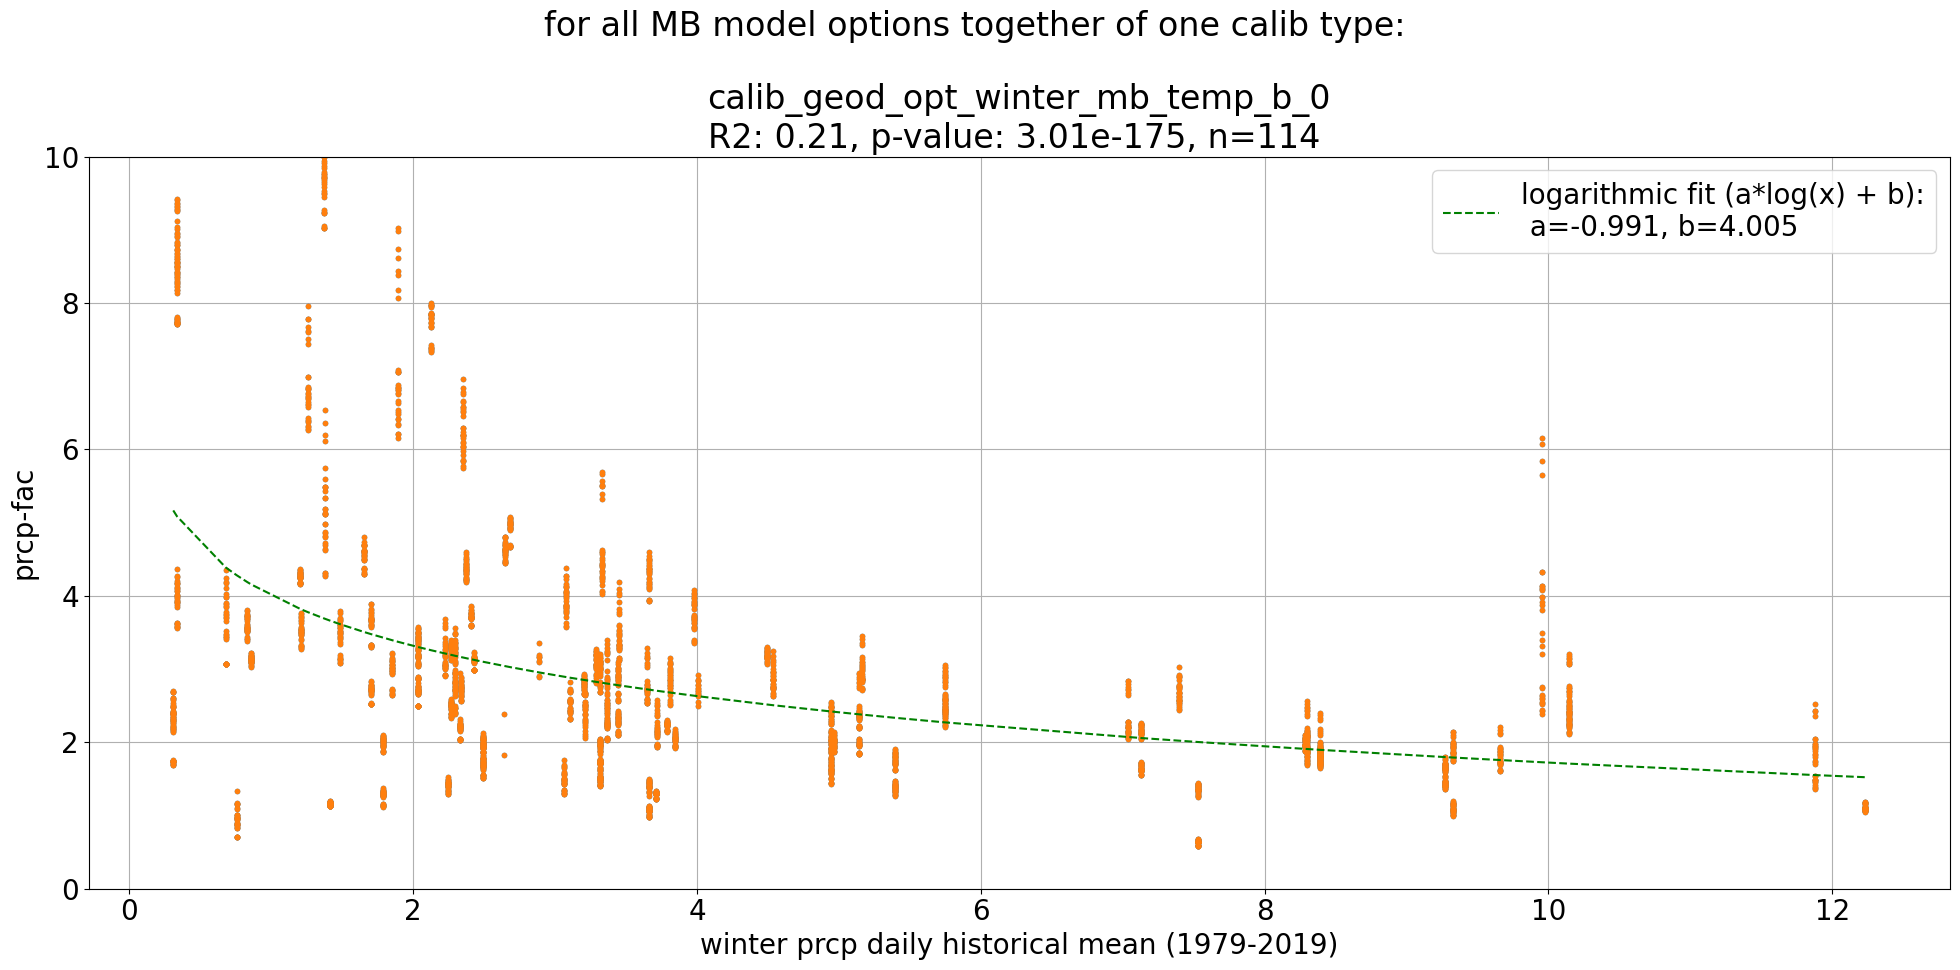

In [52]:
### first do some post-processing of the data and some pre-plots
# ATTENTION, here I use the relation 
def log_func(x, a, b):
    r = a*np.log(x) +b
    # don't allow extremely low/high prcp. factors!!!
    if len(r) == 1:
        if r > 10:
            r = 10
        if r<0.1:
            r=0.1
    else:
        r[r>10] = 10
        r[r<0.1] = 0.1
    return r

plt.figure(figsize=(20,10))
only_one_hemisphere = False #True
only_cte_grad_type = False #True #False #True #False#True
only_var_an_cycle_grad_type = False #True
hemisphere = 'all' #'nh' #'nh' #'sh' 
plt.suptitle('for all MB model options together of one calib type: ')

for j, calib_type in enumerate(['calib_geod_opt_winter_mb_temp_b_0']):
    plt.subplot(1,1,j+1)        
    pd_params_stats_t = pd_calib_type_dict[calib_type] #pd_params_stats_all.loc[pd_params_stats_all.calib_type==calib_type]
    pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.melt_f_update != 'annual']
    #pd_params_stats_t = pd_params_stats_t.dropna()
    if only_cte_grad_type:
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'cte']
    elif only_var_an_cycle_grad_type:
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.grad_type == 'var_an_cycle']
    if only_one_hemisphere:
        print(len(pd_params_stats_t.rgi_id.unique()))
        pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.hemisphere == hemisphere]
        print(len(pd_params_stats_t.rgi_id.unique()))
    # could also just take those that have a minimum area
    #pd_params_stats_t = pd_params_stats_t.loc[pd_params_stats_t.area >=0.5] # 0.15, 0.2
    plt.plot(pd_params_stats_t['daily_winter_prcp_mean_historical'], 
             pd_params_stats_t.pf_opt, '.')
    pearsonr,p_pearson = scipy.stats.pearsonr(pd_params_stats_t['daily_winter_prcp_mean_historical'],
                                                              #pd_calib_type_sel_sel.pf_opt
                                                              np.log(pd_params_stats_t.pf_opt)
                                                )
    n = len(pd_params_stats_t.rgi_id.unique())
    plt.title(f'{calib_type}\nR2: {np.square(pearsonr):.2f}, p-value: {p_pearson:.2e}, n={n} ')
    plt.ylabel('prcp-fac')
    plt.xlabel('winter prcp daily historical mean (1979-2019)')
    x = pd_params_stats_t['daily_winter_prcp_mean_historical'].dropna().values.astype('float64')
    y = pd_params_stats_t['pf_opt'].dropna().values.astype('float64')

    plt.plot(x, y, '.')

    pars, cov = scipy.optimize.curve_fit(f=log_func, xdata=x,  #pd_calib_opt_wfde5['solid prcp mean nopf weighted'].dropna(),
                                         ydata=y)
                                         #bounds=(0.0001, np.inf))

    plt.plot(np.sort(x), log_func(np.sort(x), *pars), 'g--', label='logarithmic fit (a*log(x) + b):\n a=%5.3f, b=%5.3f' % tuple(pars))

    plt.legend()
    plt.ylim([0,10])
    plt.grid()
    
plt.tight_layout()

# We are only interested in calib_geod_opt_winter_mb_temp_b_0 
pd_params_stats_t.index.name = 'None'
np.testing.assert_allclose(pd_params_stats_t.groupby('rgi_id').std()['daily_winter_prcp_mean_historical'].dropna(), 0, atol=0.01)
pd_general_log_relation_pf_prcp_winter_mb_match = pd.DataFrame(pd_params_stats_t.groupby('rgi_id').mean()['daily_winter_prcp_mean_historical'])
pd_general_log_relation_pf_prcp_winter_mb_match['daily_yearly_prcp_mean_historical'] = pd_params_stats_t.groupby('rgi_id').mean()['daily_yearly_prcp_mean_historical']
pd_general_log_relation_pf_prcp_winter_mb_match['a_log_multiplier'] = pars[0]
pd_general_log_relation_pf_prcp_winter_mb_match['b_intercept'] = pars[1]
pd_general_log_relation_pf_prcp_winter_mb_match['pf_via_log_regression'] = log_func(pd_general_log_relation_pf_prcp_winter_mb_match['daily_winter_prcp_mean_historical'],
                                                                                    pd_general_log_relation_pf_prcp_winter_mb_match['a_log_multiplier'],
                                                                                    pd_general_log_relation_pf_prcp_winter_mb_match['b_intercept'])

# will use that for another calibration option actually! 
pd_general_log_relation_pf_prcp_winter_mb_match.to_csv(f'{fpath}/0_winter_daily_prcp_mean_general_log_relation_pf_winter_mb_match.csv')

**have to run `sbatch slurm_freq_5calib.slurm "C5"` in the terminal**

In [53]:
#  ONLY if log-fit has been estimated already and 
# calib_only_geod_temp_b_0_pf_fit_via_winter_mb
ts = []
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_only_geod_no_sfc_type_pf_via_winter_mb_log_fit_{rgi_id}_methodpre-check.csv',
                        index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_only_geod_monthly_melt_f_update_pf_via_winter_mb_log_fit_{rgi_id}_methodpre-check.csv',
                        index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass
    
for rgi_id in ref_candidates:
    try:
        f = pd.read_csv(f'{path_calib_data}/calib_only_geod_annual_melt_f_update_pf_via_winter_mb_log_fit_{rgi_id}_methodpre-check.csv',
                        index_col = 'Unnamed: 0')
        ts.append(f)
    except:
        pass
pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit = pd.concat(ts)
pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit = pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.dropna(subset=['pf_opt', 'melt_f'])
pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['changing melt_f with sfc type'] = pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['melt_f_change']
out = pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.melt_f_update == 'annual'].values + '_' + 'annual'
pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.melt_f_update == 'annual'] = out
pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.loc[pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.sfc_type_distinction==False, 'changing melt_f with sfc type'] = False
pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.melt_f_change == 'neg_exp'] += '_t' + pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['tau_e_fold_yr'].loc[pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.melt_f_change == 'neg_exp'].astype(str)+'yr' 

pd_calib_type_dict['calib_only_geod_temp_b_0_pf_fit_via_winter_mb'] = pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit

/tmp/ipykernel_187646/3341818299.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.melt_f_update == 'annual'] = out
/tmp/ipykernel_187646/3341818299.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['changing melt_f with sfc type'].loc[pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit.melt_f_change == 'neg_exp'] += '_t' + pd_calib_only_geod_temp_b_0_pf_via_winter_mb_log_fit['tau_e_fold_yr'].loc[pd_calib_only_geod_temp

In [54]:
pd_calib_type_dict.keys()

dict_keys(['calib_geod_opt_winter_mb_approx_std', 'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0', 'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb'])

### Merge all in one file:

In [55]:
#pd_calib_type_dict[calib_types[0]].loc[(pd_calib_type_dict[calib_types[0]].sfc_type_distinction==True)]

In [56]:
# reestimate that?
# only look at 
pd_ts = []
for calib_type in calib_types: # no also calib_only_geod_temp_b_0_pf_fit_via_winter_mb
    pd_t = pd_calib_type_dict[calib_type]
    pd_t = pd_t.loc[pd_t.tau_e_fold_yr!=0.5]
    pd_t['calib_type'] = calib_type
    pd_ts.append(pd_t)
pd_params_stats = pd.concat(pd_ts)
pd_params_stats.index = pd_params_stats.rgi_id
pd_params_stats['mb_grad_type'] =  pd_params_stats['mb_type'].values + '_'+ pd_params_stats['grad_type'].values
pd_params_stats.loc[pd_params_stats.sfc_type_distinction == False, 'sfc_type'] = 'False'
pd_params_stats.loc[pd_params_stats.sfc_type_distinction == True,
                    'sfc_type'] = pd_params_stats.loc[pd_params_stats.sfc_type_distinction == True,
                                                      'melt_f_change'].values + '\n' + pd_params_stats.loc[pd_params_stats.sfc_type_distinction == True,
                                                                                                           'melt_f_update'].values 
pd_params_stats.loc[pd_params_stats.tau_e_fold_yr == 1.0,'sfc_type'] = pd_params_stats.loc[pd_params_stats.tau_e_fold_yr == 1.0,'sfc_type'] +'_t1.0yr'
pd_params_stats['sfc_type'].loc[pd_params_stats['sfc_type'] == 'neg_exp\nmonthly_t1.0yr'] = 'neg_exp\nmonthly_t1yr'
pd_params_stats['sfc_type'].loc[pd_params_stats['sfc_type'] == 'neg_exp\nannual_t1.0yr'] = 'neg_exp\nannual_t1yr'
pd_params_stats_all = pd_params_stats.copy()
#pd_params_stats_all = pd_params_stats_all.dropna(thresh=10)
pd_params_stats_all.to_csv(f'{fpath}/0_pd_params_stats_not_working_for_all.csv')

/tmp/ipykernel_187646/4047150346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_t['calib_type'] = calib_type
/tmp/ipykernel_187646/4047150346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_t['calib_type'] = calib_type
/tmp/ipykernel_187646/4047150346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

get the glacier param stats that work for all calib and MB model options

In [57]:
len(pd_params_stats_all)

32376

In [58]:
mb_grad_type_l_all = ['mb_monthly_cte', 'mb_monthly_var_an_cycle', 'mb_pseudo_daily_cte',
       'mb_pseudo_daily_var_an_cycle', 'mb_pseudo_daily_fake_cte',
       'mb_pseudo_daily_fake_var_an_cycle', 'mb_real_daily_cte',
       'mb_real_daily_var_an_cycle']
mb_grad_type_l_sh = ['mb_monthly_cte', 'mb_monthly_var_an_cycle',  'mb_real_daily_cte',
                     'mb_pseudo_daily_fake_cte',
       'mb_pseudo_daily_fake_var_an_cycle',
       'mb_real_daily_var_an_cycle']

In [59]:
j = 0
for calib_type in pd_params_stats_all.calib_type.unique():
    for sfc_type in ['False', 'linear\nmonthly', 'neg_exp\nmonthly_t1yr']:
                     #pd_params_stats_all.sfc_type.unique():
        for mb_grad_type in mb_grad_type_l_sh:
            _sel = pd_params_stats_all.loc[((pd_params_stats_all.calib_type==calib_type)
                                            & (pd_params_stats_all.sfc_type==sfc_type) 
                                            & (pd_params_stats_all.mb_grad_type==mb_grad_type))]
            rgi_id_w = _sel.rgi_id.unique()
            #print(f'{calib_type}_{sfc_type}_{len(rgi_id_w)}')
            if j == 0:
                working_rgi_l = rgi_id_w
            else:
                working_rgi_l = list(set(working_rgi_l).intersection(rgi_id_w))
            #print(len(working_rgi_l))
            j+=1

# save the working rgi list again ... 
pd.DataFrame(working_rgi_l).to_csv(f'{fpath}/0_rgi_working_for_all_list.csv')
#rgi_working_for_all = list(rgi_working_for_all['0'].values)
pd_params_stats_w_all = pd_params_stats_all.loc[working_rgi_l]            
            
pd_params_stats_w_all.to_csv(f'{fpath}/0_pd_params_stats_working_for_all.csv')

In [60]:
len(pd_params_stats_w_all.index.unique())

88

In [61]:
len(working_rgi_l)

88

just a test if `mb_pseudo_daily` and `mb_pseudo_daily_fake` have similar calib options!

In [62]:
pd_t = pd_params_stats_all.copy()

pd_t = pd_t.set_index(pd_t.rgi_id)
pd_t = pd_t.loc[working_rgi_l].reset_index(drop=True)
vals = pd_t[['melt_f', 'mb_type']].groupby('mb_type').median().loc[['mb_pseudo_daily',
                                                                    'mb_pseudo_daily_fake'],
                                           'melt_f'].values
np.testing.assert_allclose((vals[0]-vals[1])/vals[0], 0, atol=0.01)

**write calib_params_to_gdirs**

In [107]:
write_calib_params_to_gdirs = False
climate_type = 'W5E5'

not_working_dict = {}
if write_calib_params_to_gdirs:
    for calib_type in calib_types:
        not_working = []
        if (calib_type == 'calib_geod_opt_std_temp_b_0') or (calib_type=='calib_only_geod_temp_b_0_pf_cte_via_std')
            or (calib_type == 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb'):
            # works only for those calibration methods that do not use winter MB for calibration! 
            sfc_type_list = ['False', 'linear', 'neg_exp_t1.0yr', 'linear_annual',
                             'neg_exp_annual_t1.0yr']
        else:
            sfc_type_list = ['False', 'linear', 'neg_exp_t1.0yr']
        for sfc_type in sfc_type_list:
            pd_calib_type = pd_calib_type_dict[calib_type]
            pd_calib_type['changing melt_f with sfc type'].loc[pd_calib_type['changing melt_f with sfc type'] == False] = 'False'
            pd_calib_pre_sel = pd_calib_type.loc[pd_calib_type['changing melt_f with sfc type']==sfc_type]

            pd_calib_pre_sel = pd_calib_pre_sel.loc[pd_calib_pre_sel.tau_e_fold_yr != 0.5] # only 1.0 or None!!! 
            for mb_type in pd_calib_pre_sel.mb_type.unique():
                pd_calib_sel = pd_calib_pre_sel.loc[pd_calib_pre_sel.mb_type == mb_type]
                for grad_type in pd_calib_sel.grad_type.unique():
                    pd_calib_sel_sel = pd_calib_sel.loc[pd_calib_sel.grad_type == grad_type]

                    for gdir in gdirs:
                        rgi_id = gdir.rgi_id
                        pd_calib_rgi = pd_calib_sel_sel.loc[pd_calib_sel_sel.rgi_id == rgi_id]
                        if len(pd_calib_rgi) == 1:
                            # TODO: maybe also add type of mb_model_sub_class into fs ???
                            if '_t1.0yr' in sfc_type:
                                sfc_type_sub = sfc_type[:-len('_t1.0yr')]
                            else:
                                sfc_type_sub = sfc_type
                            fs_new = '_{}_sfc_type_{}_{}_{}'.format(climate_type,
                                                                    sfc_type_sub,
                                                                    mb_type, grad_type)
                            d = {'melt_f': pd_calib_rgi.melt_f.values[0],
                                 'pf': pd_calib_rgi.pf_opt.values[0],
                                 'temp_bias': pd_calib_rgi.temp_bias.values[0],
                                 'tau_e_fold_yr': pd_calib_rgi.tau_e_fold_yr.values[0]}
                            gdir.write_json(d, filename=calib_type, filesuffix=fs_new)
                        else:
                            not_working.append(gdir.rgi_id)
                        if len(pd_calib_rgi)>1:
                            f = pd_calib_rgi.copy()
                            print(f'{gdir.rgi_id} sth. wrong')
        not_working_dict[calib_type] = not_working
        
        print(len(set(not_working_dict[calib_type])))

**also already add the future climate :**

In [108]:
load = False
if load:
    gcms = ['ukesm1-0-ll','gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0' ]
    correction = False
    for ensemble in gcms:
        if ensemble == 'ukesm1-0-ll':
            ensemble = ensemble + '_r1i1p1f2'
        else:
            ensemble = ensemble + '_r1i1p1f1'

        if correction:
            workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                     ssp = ssp, temporal_resol ='monthly',
                                      climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type) )
            workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                     ssp = ssp, temporal_resol ='daily',
                                      climate_historical_filesuffix='_{}_{}'.format('daily', climate_type) )
        else:
            #workflow.execute_entity_task(process_isimip_data_no_corr, gdirs, ensemble = ensemble,
            #                         ssp = ssp, temporal_resol ='monthly',
            #                          climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type) )
            #workflow.execute_entity_task(process_isimip_data_no_corr, gdirs, ensemble = ensemble,
            #                         ssp = ssp, temporal_resol ='daily',
            #                          climate_historical_filesuffix='_{}_{}'.format('daily', climate_type) )
            workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                     ssp = 'ssp126', temporal_resol ='monthly',
                                      climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type), correct=correction )
            workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                     ssp = 'ssp126', temporal_resol ='daily',
                                      climate_historical_filesuffix='_{}_{}'.format('daily', climate_type), correct=correction )
            workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                     ssp = 'ssp585', temporal_resol ='monthly',
                                      climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type), correct=correction )
            workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                         ssp = 'ssp585', temporal_resol ='daily',
                                          climate_historical_filesuffix='_{}_{}'.format('daily', climate_type), correct=correction )

    #Computes the Flowline along the unglaciated downstream topography
    workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    # The bedshape obtained by fitting a parabola to the line’s normals. Also computes the downstream’s altitude.
    workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)

**files that are copied to my Laptop and used to create the Figures**
- scp lschuster@cluster:/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/data